# **Netflix Movie Recommendation System**

**Objective:** 
* The objective of this project is to develop a recommendation system for Netflix users based on historical ratings data. By utilizing both collaborative filtering techniques (SVD) and content-based filtering (Pearson Correlation), the system aims to predict movie ratings and recommend movies that are most likely to match users' preferences. The system will also provide personalized suggestions, improving user experience and engagement on the platform.

**Problem Description:** 
* Netflix, like many content platforms, faces the challenge of delivering personalized content recommendations to its vast user base. With millions of movies and shows available, users often struggle to discover new content that aligns with their tastes. The dataset used in this project contains historical movie ratings from users, and the goal is to predict which movies a user might like based on their past interactions and the ratings of other users with similar tastes. A robust recommendation system will help Netflix increase user satisfaction and retention by offering relevant suggestions.

**Scope of the Solution:** 
* This solution will focus on implementing two key recommendation techniques:

    * Collaborative Filtering using Singular Value Decomposition (SVD): This technique will leverage historical ratings data to predict ratings for unrated movies and suggest items to users based on their preferences and the preferences of similar users.
    * Content-Based Filtering using Pearson Correlation: This approach will recommend similar movies based on the correlation of user ratings, allowing the system to suggest movies that are similar to the ones the user has rated highly.
The solution will include data preprocessing steps such as cleaning, removing low-rated movies, and handling missing values. The final model will predict ratings for a given user and recommend a list of top 10 movies based on similarity.

**Expected Outcome:** 
* The expected outcome of this project is a fully functional recommendation system capable of providing personalized movie suggestions to Netflix users. The system should:

    * Predict ratings for movies that users have not rated yet.
    * Recommend movies that are similar to a user's preferences.
    * Demonstrate improved user engagement by offering highly relevant movie suggestions.
    * Evaluate the model's performance using cross-validation and metrics such as RMSE and MAE to ensure accuracy and reliability in the recommendations.

### 1. Import Libraries

In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate


### 2. Load the Dataset (Data Viewing)

In [73]:
# List files in the current directory
os.listdir()

# Load the dataset
netflix_dataset = pd.read_csv(
    'combined_data_1.txt',
    header=None,
    names=["Cust_ID", "Rating"],
    usecols=[0, 1]
)

# Display dataset size and a preview
print(f"The dataset contains {netflix_dataset.shape[0]} rows and {netflix_dataset.shape[1]} columns")
netflix_dataset.head()


The dataset contains 24058263 rows and 2 columns


,Cust_ID,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


### 3. Inspect the Dataset

In [74]:
## Checking the data types
netflix_dataset.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_ID  object 
 1   Rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB



### 4. Data viewing

In [75]:
## Group Ratings Count
rating = netflix_dataset.groupby("Rating")["Rating"].agg(["count"])
rating

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


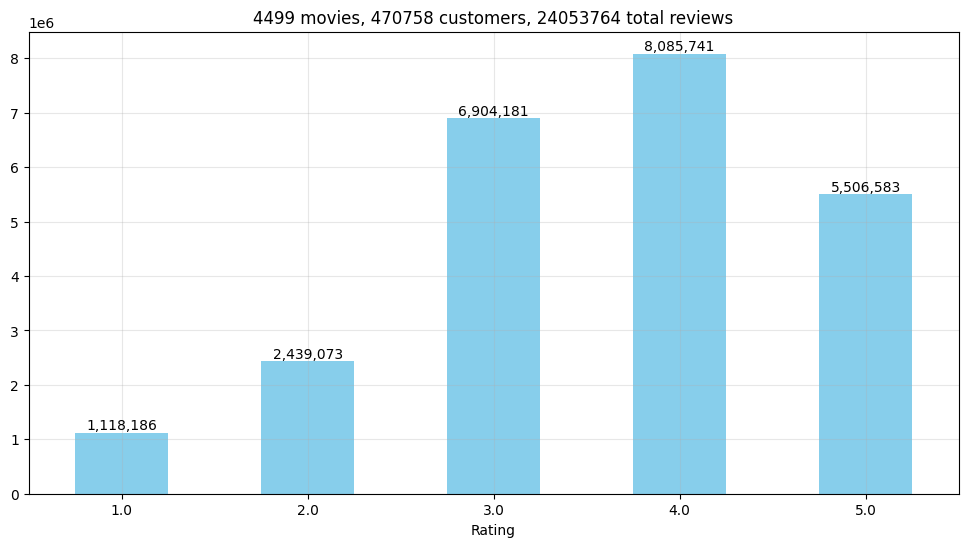

In [76]:
# 4. Data Viewing

# Step 1: Grouping Ratings by Count
# Group the data by the 'Rating' column and count the number of occurrences for each rating.
rating = netflix_dataset.groupby("Rating")["Rating"].agg(["count"])

# Step 2: Calculate the Total Number of Movies
# The number of movies is the count of NaN values in the 'Rating' column.
movie_count = netflix_dataset["Rating"].isna().sum()

# Step 3: Calculate the Total Number of Customers
# The total number of unique customers, excluding rows where 'Rating' is NaN.
Total_customers = netflix_dataset["Cust_ID"].nunique() - movie_count

# Step 4: Calculate the Total Number of Ratings
# The total number of ratings is the count of 'Cust_ID' entries, excluding the NaN values.
total_rating = netflix_dataset["Cust_ID"].count() - movie_count

# Step 5: Visualize the Rating Data
# Plot the number of ratings as a bar chart.
rating.plot(kind="bar", figsize=(12, 6), color="skyblue", legend=False)

# Step 6: Add Title and Grid to the Plot
# Add a title showing the total number of movies, customers, and ratings.
plt.title(f"{movie_count} movies, {Total_customers} customers, {total_rating} total reviews")

# Add a grid for better readability.
plt.grid(axis='both', alpha=0.3)

# Step 7: Annotate the Bars with the Counts
# Add the exact count of each rating on top of the corresponding bar.
for index, value in enumerate(rating["count"]):
    plt.text(index, value, f"{value:,}", ha="center", va="bottom")

# Step 8: Rotate X-axis Labels
# Ensure the rating labels on the x-axis are horizontal for readability.
plt.xticks(rotation=0)

# Step 9: Display the Plot
plt.show()


> Highest Reviews at 4-star: 
* The bar for the 4-star rating has the highest number of reviews, with over 8 million reviews. This suggests that a large portion of the movies in the dataset have been well-received by customers, earning high ratings.
> Substantial 5-star Reviews: 
* The 5-star rating bar shows the second-highest number of reviews, with over 5.5 million. This indicates that a significant number of movies have received excellent customer feedback.
> Fewer Low-rated Movies: 
* The 1-star and 2-star rating bars have the lowest number of reviews, around 1.1 million and 2.4 million, respectively. This implies that the dataset contains fewer movies that have been poorly rated by customers.
> Large Customer Base: 
* With 475,257 customers providing a total of 24,053,764 reviews, this dataset represents a substantial user base engaging with the movies.
> Diverse Rating Distribution: 
* The chart shows a varied distribution of reviews across the different rating levels, suggesting that the dataset contains a mix of movies with different levels of customer satisfaction.

### 5. Data Cleaning

#### 5.1 Removing Null values, and adding seperate movie ID columns

* **Purpose:** The dataset combines both movie IDs and customer ratings in the same 'Cust_ID' column. This step extracts movie IDs and ensures each row has a clear association with a movie.

* **Why It's Needed:** Movie IDs are marked with a colon (":"). We need to extract these IDs separately to associate each rating with the correct movie.

* **Removing Null Ratings:** Since some rows are movie identifiers (with no ratings), filtering out rows with null values in the 'Rating' column ensures that only meaningful rating data remains.

In [77]:
# Extract movie IDs and add them to a new column
current_movie_id = None
movie_id = []

for id in netflix_dataset["Cust_ID"]:
    if ":" in id:
        current_movie_id = int(id.replace(":", ""))
    movie_id.append(current_movie_id)

# Add the movie IDs to the dataset
netflix_dataset["Movie_ID"] = movie_id

# Remove rows where Rating is null (movie IDs)
netflix_dataset = netflix_dataset[netflix_dataset["Rating"].notna()]
netflix_dataset

# Inspect the dataset
netflix_dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24053764 entries, 1 to 24058262
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   object 
 1   Rating    float64
 2   Movie_ID  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 734.1+ MB


In [78]:
## Checking the Null values after adding the movie ID columns
netflix_dataset.isna().sum()

Cust_ID     0
Rating      0
Movie_ID    0
dtype: int64

In [79]:
## Converting the object columns into interger columns
netflix_dataset["Cust_ID"] = netflix_dataset["Cust_ID"].astype(int)

#### 5.2. Removing the least rated movie 

* **Purpose:** Identify and remove movies that have too few ratings.

* **Why It's Needed:** Movies with very few ratings might not provide enough information for accurate predictions. Removing these ensures that the model focuses on movies with sufficient feedback.

* **Quantile Threshold:** The quantile(0.6) sets a threshold to drop the bottom 40% of movies based on the number of ratings. This helps in keeping only the most frequently rated movies for a better recommendation system.

In [80]:
# Calculate the number of ratings per movie
all_movie_summary = netflix_dataset.groupby("Movie_ID")["Rating"].agg(["count"])

# Set a benchmark to filter movies (60th percentile)
movie_benchmark = round(all_movie_summary["count"].quantile(0.6), 0)

# Identify movies with fewer ratings than the benchmark
drop_movie_list = all_movie_summary[all_movie_summary["count"] < movie_benchmark].index


#### 5.3. Removing the customers Customers with Low Rating Activity

* **Purpose:** Identify and remove customers who have rated very few movies.

* **Why It's Needed:** Customers with minimal rating activity do not provide enough information for accurate preference modeling. Including such customers may lead to poor model performance.

* **Quantile Threshold:** The quantile(0.6) sets a threshold to drop the bottom 40% of customers based on the number of ratings they provided. This ensures that only active customers are included in the dataset.


In [81]:
# Calculate the number of ratings per customer
all_customer_Data = netflix_dataset.groupby("Cust_ID")["Rating"].agg(["count"])

# Set a benchmark to filter customers (60th percentile)
customer_benchmark = round(all_customer_Data["count"].quantile(0.6), 0)

# Identify customers with fewer ratings than the benchmark
drop_customer_list = all_customer_Data[all_customer_Data["count"] < customer_benchmark].index


#### 5.4. Dropping the Least Rated Movies and Customers with Low Rating Activity

* **Purpose:** Apply the filtering criteria to drop both the least-rated movies and inactive customers from the dataset.

* **Why It's Needed:** By removing less informative data, we ensure that the dataset contains only high-quality information, making the recommendation system more reliable.

* **Final Dataset Size:** After this step, a print statement shows the new size of the dataset to confirm the data reduction.

In [82]:
# Drop least rated movies and low-activity customers
netflix_dataset = netflix_dataset[~netflix_dataset["Movie_ID"].isin(drop_movie_list)]
netflix_dataset = netflix_dataset[~netflix_dataset["Cust_ID"].isin(drop_customer_list)]

print(f"After trimming the data, there are {netflix_dataset.shape[0]} rows and {netflix_dataset.shape[1]} columns")


After trimming the data, there are 19695836 rows and 3 columns


#### Summary of Data Cleaning Process
> Extract Movie IDs and Filter Null Ratings: 
* Ensures each row has a clear Movie_ID and removes entries with no ratings.
> Remove Least Rated Movies: 
* Focuses on movies that have enough ratings to make reliable predictions.
> Remove Inactive Customers: 
* Includes only customers who have rated enough movies to reflect meaningful preferences.
> Trim the Dataset: 
* Final filtering step to keep only the most relevant data.

<hr>

### 6. Loading Movie Titles

* **Purpose:** Load the movie titles dataset that contains metadata about the movies, including Movie_ID, Year, and Name.

* **Why It's Needed:** The recommendation model works with Movie_ID numbers, which aren't user-friendly. Loading movie titles allows us to map Movie_ID to human-readable names and years.

* **Encoding:** The ISO-8859-1 encoding ensures that special characters in movie names are properly read.

* **Columns Used:** Only the relevant columns (Movie_ID, Year, Name) are loaded, keeping the dataset concise.

In [83]:
df_title = pd.read_csv("movie_titles.csv" , encoding = 'ISO-8859-1', header=None, usecols=[0,1,2], names=["Movie_ID", "Year", "Name"])
df_title

,Movie_ID,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


### 7. Load Data for SVD

* **Purpose:** Load the dataset into a format compatible with the Surprise library.

* **Why It's Needed:** The Surprise library requires data in a specific format (Cust_ID, Movie_ID, Rating) for training models.

* **Sample Size:** Only the first 100,000 rows are used for this initial step to test the model quickly and ensure it works correctly before using the full dataset.

In [84]:
# Prepare the dataset for Surprise library
reader = Reader()
data = Dataset.load_from_df(netflix_dataset[["Cust_ID", "Movie_ID", "Rating"]][:100000], reader)


#### 7.1. Initialize and Evaluate SVD Model
* **Purpose:** Initialize and evaluate the SVD model using cross-validation.
* **Why It's Needed:**
    * **Model Selection:** SVD is a popular method for collaborative filtering.
    * **Cross-Validation:** Performing 5-fold cross-validation helps ensure the model's performance is consistent across different subsets of the data.
    * **Evaluation Metrics:** RMSE and MAE provide insights into how accurate the model's predictions are.

In [85]:
# Initialize and cross-validate the SVD model
model_svd = SVD()
cross_validate(model_svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0194  1.0181  1.0143  1.0223  1.0168  1.0182  0.0027  
MAE (testset)     0.8118  0.8132  0.8082  0.8218  0.8130  0.8136  0.0045  
Fit time          1.93    1.76    1.44    1.45    1.47    1.61    0.20    
Test time         0.36    0.16    0.16    0.46    0.16    0.26    0.13    


{'test_rmse': array([1.01943664, 1.01813226, 1.01429784, 1.02231481, 1.01681755]),
 'test_mae': array([0.81184623, 0.81315431, 0.80823905, 0.82184007, 0.8130091 ]),
 'fit_time': (1.9338271617889404,
  1.7573046684265137,
  1.4411475658416748,
  1.4470922946929932,
  1.4690358638763428),
 'test_time': (0.3580455780029297,
  0.16256284713745117,
  0.16053247451782227,
  0.46276378631591797,
  0.1596081256866455)}

#### 7.2 Training the model with full Dataset
* **Purpose:** Train the SVD model on the full dataset.
* **Why It's Needed:**
    * **Full Dataset Training:** After verifying the model's performance with a subset, training on the full dataset ensures it learns from all available data.
    * **Model Fitting:** The fit() method applies the SVD algorithm to the entire training set, preparing the model for making predictions.

In [86]:
# Train the model on the full dataset
data = Dataset.load_from_df(netflix_dataset[["Cust_ID", "Movie_ID", "Rating"]], reader)
train_set = data.build_full_trainset()
model_svd.fit(train_set)

### 8. Predict Scores for a Specific Customer
This step involves predicting ratings for a specific customer based on their preferences and the movies they have rated.

In [87]:
# Predict ratings for customer 712664
cust_712664 = df_title.copy()
cust_712664 = df_title[~df_title["Movie_ID"].isin(drop_movie_list)]
cust_712664["Predicted_rating"] = cust_712664["Movie_ID"].apply(lambda x: model_svd.predict(712664, x).est)


C:\Users\Asus-PC\AppData\Local\Temp\ipykernel_27864\3979077147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_712664["Predicted_rating"] = cust_712664["Movie_ID"].apply(lambda x: model_svd.predict(712664, x).est)


In [95]:
cust_712664["Predicted_rating"] = cust_712664["Movie_ID"].apply(lambda x: model_svd.predict(712664, x).est)
cust_712664.sort_values(by = "Predicted_rating", ascending = False)

C:\Users\Asus-PC\AppData\Local\Temp\ipykernel_27864\4285002130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_712664["Predicted_rating"] = cust_712664["Movie_ID"].apply(lambda x: model_svd.predict(712664, x).est)


,Movie_ID,Year,Name,Predicted_rating
1691,1692,1989.0,Lonesome Dove,5.000000
1276,1277,1988.0,Red Dwarf: Series 3,5.000000
2194,2195,2004.0,The Looney Tunes Golden Collection: Vol. 2,5.000000
2404,2405,2003.0,MI-5: Vol. 2,5.000000
2753,2754,2002.0,The Life of Mammals,5.000000
...,...,...,...,...
1524,1525,2001.0,Monkeybone,1.293051
2336,2337,1997.0,Double Team,1.238583
361,362,2000.0,The Flintstones in Viva Rock Vegas,1.197944
2275,2276,1998.0,Spice World,1.181217


In [98]:
cust_712664.sort_values(by = "Predicted_rating", ascending = False)["Name"].head(10).tolist()

['Lonesome Dove',
 'Red Dwarf: Series 3',
 'The Looney Tunes Golden Collection: Vol. 2',
 'MI-5: Vol. 2',
 'The Life of Mammals',
 'Nausicaa of the Valley of the Wind',
 'The Godfather',
 'The West Wing: Season 3',
 'Lost: Season 1',
 'Futurama: Monster Robot Maniac Fun Collection']

### 9. Content-based filtering recommendation system using Pearson correlation
The content-based recommendation system uses Pearson correlation to recommend movies similar to a given movie based on customer ratings.

In [89]:
# Load the cleaned Netflix dataset
netflix_dataset

,Cust_ID,Rating,Movie_ID
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3
...,...,...,...
24056842,1055714,5.0,4496
24056843,2643029,4.0,4496
24056844,267802,4.0,4496
24056845,1559566,3.0,4496


In [90]:
# Load movie titles
df_title


,Movie_ID,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


#### 9.1 Data Preparation:
* The function starts by converting the Netflix dataset into a user-movie matrix using pivot_table.
* This matrix will have customers as rows and movies as columns with the ratings as values. This step is critical as it sets up the data for calculating similarity between movies.

In [91]:
user_movie_matrix = netflix_dataset.pivot_table(
    index='Cust_ID',
    columns='Movie_ID',
    values='Rating'
)

user_movie_matrix.head()


Movie_ID,3,5,6,8,16,17,18,24,25,26,...,4482,4483,4484,4485,4488,4489,4490,4492,4493,4496
Cust_ID,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 9.2 Recommending similar movies
* This function recommends movies based on Pearson correlation similarity. It computes the similarity between the target movie and all other movies in the user-movie matrix based on ratings.

* Parameters:
  - movie_name (str): The name of the movie for which recommendations are to be made.
  - user_movie_matrix (pd.DataFrame): A matrix where each row represents a customer, 
      and each column represents a movie with ratings as values.
  - df_title (pd.DataFrame): A DataFrame containing movie IDs and their corresponding movie names.

* Returns:
  - List of top 10 recommended movie names similar to the specified movie.

In [92]:
def recommend_similar_movies(movie_name, user_movie_matrix, df_title):
    """
    This function recommends movies based on Pearson correlation similarity.
    It computes the similarity between the target movie and all other movies 
    in the user-movie matrix based on ratings.

    Parameters:
    - movie_name (str): The name of the movie for which recommendations are to be made.
    - user_movie_matrix (pd.DataFrame): A matrix where each row represents a customer, 
      and each column represents a movie with ratings as values.
    - df_title (pd.DataFrame): A DataFrame containing movie IDs and their corresponding movie names.

    Returns:
    - List of top 10 recommended movie names similar to the specified movie.
    """

    try:
        # Step 1: Find the Movie ID based on the provided movie name
        movie_id = df_title[df_title["Name"].str.contains(movie_name, case=False, na=False)].iloc[0]["Movie_ID"]
        
        # Step 2: Extract ratings for the target movie
        target_movie_rating = user_movie_matrix[movie_id]
        
        correlations = {}
        
        # Step 3: Compute Pearson correlation between the target movie and all other movies
        for col in user_movie_matrix.columns:
            if col != movie_id:  # Avoid comparing the movie with itself
                correlation = target_movie_rating.corr(user_movie_matrix[col], method="pearson")
                correlations[col] = correlation
        
        # Step 4: Sort the movies based on similarity (Pearson correlation)
        sorted_correlation = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
        
        # Step 5: Select top 10 most similar movies
        similar_movie_ids = [movie_id for movie_id, corr in sorted_correlation[:10]]
        
        # Step 6: Retrieve movie names for the most similar movies
        similar_movies = df_title[df_title["Movie_ID"].isin(similar_movie_ids)]["Name"].tolist()
        
    except IndexError:
        # Error handling if the movie name is not found in the dataset
        print(f"Movie '{movie_name}' is not found in the database.")
        return []

    return similar_movies


In [93]:
movie_name = "X-Men United"
recommend_similar_movies(movie_name, user_movie_matrix, df_title)

['Justice League',
 'Roughnecks: The Starship Troopers Chronicles: The Pluto Campaign',
 'Spider-Man vs. Doc Ock',
 'Batman Beyond: Tech Wars / Disappearing Inque',
 'Gargoyles: Season 1',
 'Justice League: Justice on Trial',
 'Silent Rage',
 'Batman Beyond: Return of the Joker',
 'Batman Beyond: The Movie',
 'Batman: The Animated Series: Out of the Shadows']

### 10. Conclusion:
Combining SVD and Pearson Correlation for content-based filtering leverages the strengths of both techniques, ensuring that the system can handle both sparse and dense data effectively. SVD excels in identifying latent factors and predicting ratings for unrated items, while Pearson correlation provides a simple, direct measure of item similarity based on user preferences. Together, these methods enhance the quality of recommendations by balancing both complex and straightforward relationships between movies, ensuring that users are presented with a diverse yet highly relevant set of suggestions.